# Creating comet models

In [1]:
import os, sys
sys.path.insert(1,'/Users/azib/Documents/open_source/nets/scripts/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets/stella/')
import numpy as np
import build_synthetic_set as models
from utils import *
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella

/Users/azib/micromamba/envs/nets/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


## TESS S28 lightcurves
- S28 is taken as random test sample.
- 10-minute SPOC data.
- Possibly we'll need to generate models for each sector to account for the sector-related noise properties?

- Caveat: the flares dataset sets the "start times" of the flare, we have it set as the midtransit point.

### Generate the models

In [2]:
files = glob('../data/s0028/**/*.fits', recursive=True)
len(files)

107973

In [3]:
files[0:2]

['../data/s0028/target/0000/0003/9452/1607/hlsp_tess-spoc_tess_phot_0000000394521607-s0028_tess_v1_lc.fits',
 '../data/s0028/target/0000/0003/9452/1654/hlsp_tess-spoc_tess_phot_0000000394521654-s0028_tess_v1_lc.fits']

In [205]:
os.makedirs('../models2/', exist_ok=True)
fails = []
times = []
ticid = []
for i in tqdm(files[0:50000]):
    try:
        lc, info = import_lightcurve(i)
        tic = info['TICID']
        flat_flux = wotan.flatten(lc['TIME'], lc['SAP_FLUX'], method='median', window_length=1)
        rms = np.std(flat_flux)
    
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]
    
        min_snr = 2
        max_snr = 20 
        random_snr = np.random.uniform(min_snr,max_snr)
        
        A = rms * random_snr
        
            # Initialize a flag to indicate whether a valid time has been found
        valid_time_found = False
    
        while not valid_time_found:
            t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
        
            # Check if the current random start time falls within any large gap or within 1.5 days before or after a gap
            for index in large_gaps_indices:
                start_time = lc['TIME'][index] - 1
                end_time = lc['TIME'][index + 1] + 1
                if start_time <= t0 <= end_time:
                    # Current random start time falls within a data gap or within 1.5 days before or after a gap, select a new one
                    break
                elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                    # Current random start time is within 1.5 days after a data gap, select a new one
                    break
                elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                    # Current random start time is within 1.5 days before a data gap, select a new one
                    break
                elif t0 <= lc['TIME'][0] + 1:
                    # Current random start time is within one day after the beginning of the lightcurve, select a new one
                    break
                elif t0 >= lc['TIME'][-1] - 2:
                    # Current random start time is within two days before the end of the lightcurve, select a new one
                    break
            else:
                # Current random start time doesn't fall within any data gap, 1.5 days before or after a gap, or special conditions, set the flag to True
                valid_time_found = True


        model = 1 - models.comet_curve(lc['TIME'], A, t0)
        flux = model * flat_flux
        #flux = flux/np.nanmedian(lc['SAP_FLUX'])
        fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))
    
        time = np.array(lc['TIME'])
        flux = np.array(flux)
        times.append(t0)
        ticid.append(tic)
    
        np.save(f"../models2/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
        #np.save(f"../models/{info['TICID']}_sector28-time.npy", np.array([t0]))
    except TypeError as e:
        fails.append(i)
        print(f"Exception occurred for file {i}: {e}. Continuing...")
        continue

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 32124/50000 [20:12<11:06, 26.80it/s]

Exception occurred for file ../data/s0028/target/0000/0002/8009/6487/hlsp_tess-spoc_tess_phot_0000000280096487-s0028_tess_v1_lc.fits: buffer is too small for requested array. Continuing...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [30:42<00:00, 27.14it/s]


### Converting non-model lightcurves to `.npy` arrays

Issue: no. of injected lightcurves must be more than test sample

In [7]:
# for i in tqdm(files[10000:20000]):
#     try:
#         lc, info = import_lightcurve(i)
#         tic = info['TICID']
    
#         fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))

#         time = np.array(lc['TIME'])
#         flux = np.array(lc['SAP_FLUX'] / np.nanmedian(lc['SAP_FLUX']))
#         np.save(f"../models/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
#     except TypeError:
#         continue

100%|██████████████████████████████████████████████████████████████| 10000/10000 [03:53<00:00, 42.87it/s]


## Sanity check: Read in flare models and plot grid
- numpy files are time, flux (normalised), flux error

In [5]:
flares = glob('../stella-tests/lc/*.npy')
flares[0:5]

['../stella-tests/lc/197757864_sector01.npy',
 '../stella-tests/lc/279055830_sector02.npy',
 '../stella-tests/lc/002760232_sector02.npy',
 '../stella-tests/lc/364302118_sector02.npy',
 '../stella-tests/lc/246861224_sector02.npy']

In [6]:
stellas = np.load('../stella-tests/lc/197757864_sector01.npy')
stellas

array([[1.32530082e+03, 1.32530221e+03, 1.32530360e+03, ...,
        1.35317873e+03, 1.35318012e+03, 1.35318151e+03],
       [1.00055659e+00, 9.87374187e-01, 9.97535467e-01, ...,
                   nan,            nan,            nan],
       [7.57158315e-03, 7.54949823e-03, 7.56265502e-03, ...,
                   nan,            nan,            nan]])

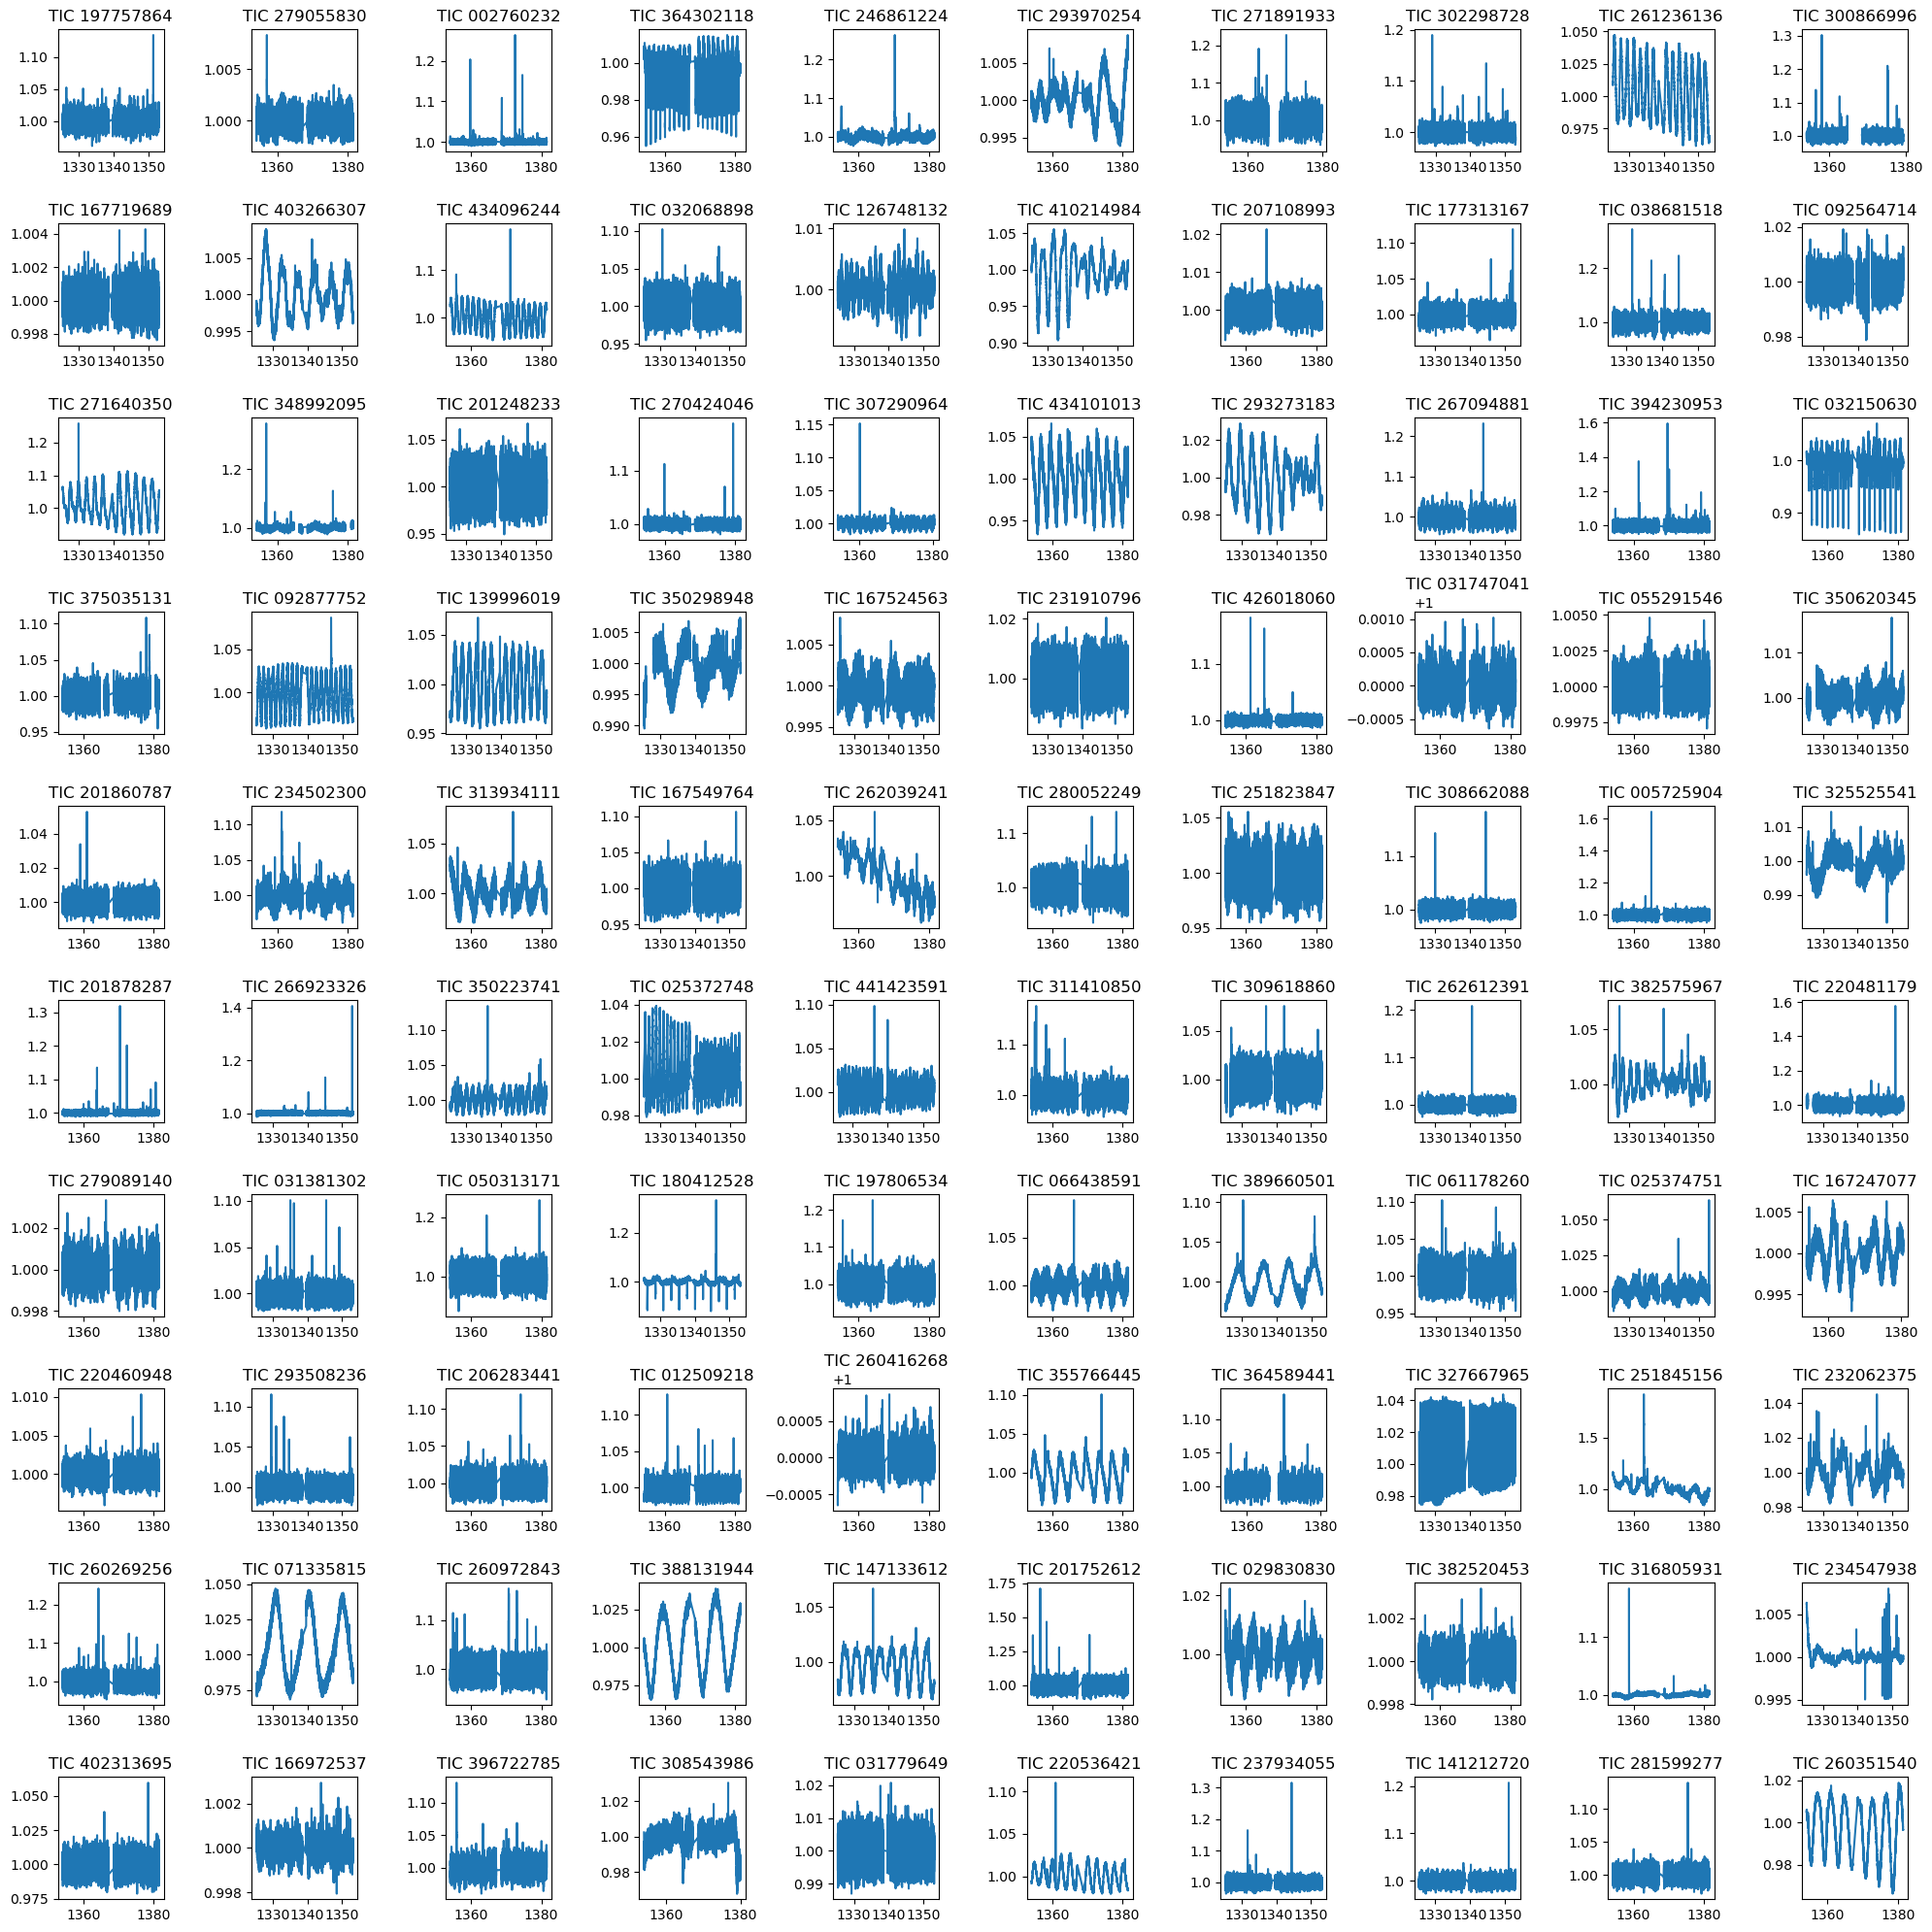

In [7]:
file_paths = glob('../stella-tests/lc/*.npy')

num_files_per_grid = 100

# Loop through the file paths in chunks of num_files_per_grid
for i in range(0, len(file_paths), num_files_per_grid):
    batch_paths = file_paths[i:i+num_files_per_grid]
    num_rows, num_cols = 10, 10
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    for j, path in enumerate(batch_paths):
        file = np.load(path)
        time, flux, fluxerror = file

        # Extract the file ID from the path
        file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

        row = j // num_cols
        col = j % num_cols

        axs[row, col].plot(time, flux)
        axs[row, col].set_title(f'TIC {file_id}')

    plt.tight_layout()
    plt.show()
    break

## Loading comet models

In [5]:
comets =  glob('../models/*.npy')
comets[0:3]

['../models/300812713_sector28.npy',
 '../models/300449607_sector28.npy',
 '../models/394681312_sector28.npy']

### Sample plot of Full Lightcurves

In [6]:
# num_files_per_grid = 100

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 10, 10
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path,allow_pickle=True)
#         time = file[0]
#         flux = file[1]/np.nanmedian(file[1])


        
#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]
        

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
#     break

## Build catalog

In [209]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
t = Table.from_pandas(data)

In [210]:
t.write('catalog-test2.txt', format='ascii', overwrite=True) 

In [211]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets/models2/',
                         catalog='/Users/azib/Documents/open_source/nets/notebooks/catalog-test2.txt',cadences=450,training=0.8,validation=0.9)

Reading in training set files.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49999/49999 [00:23<00:00, 2109.91it/s]


49999 positive classes (flare)
38722 negative classes (no flare)
129.0% class imbalance



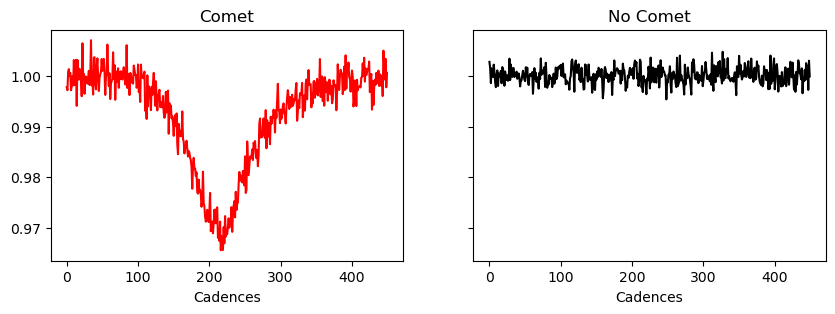

In [212]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[1]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[10]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

## Example of Exocomet Models

In [213]:
dsmodels = ds.train_data[ind_pc]

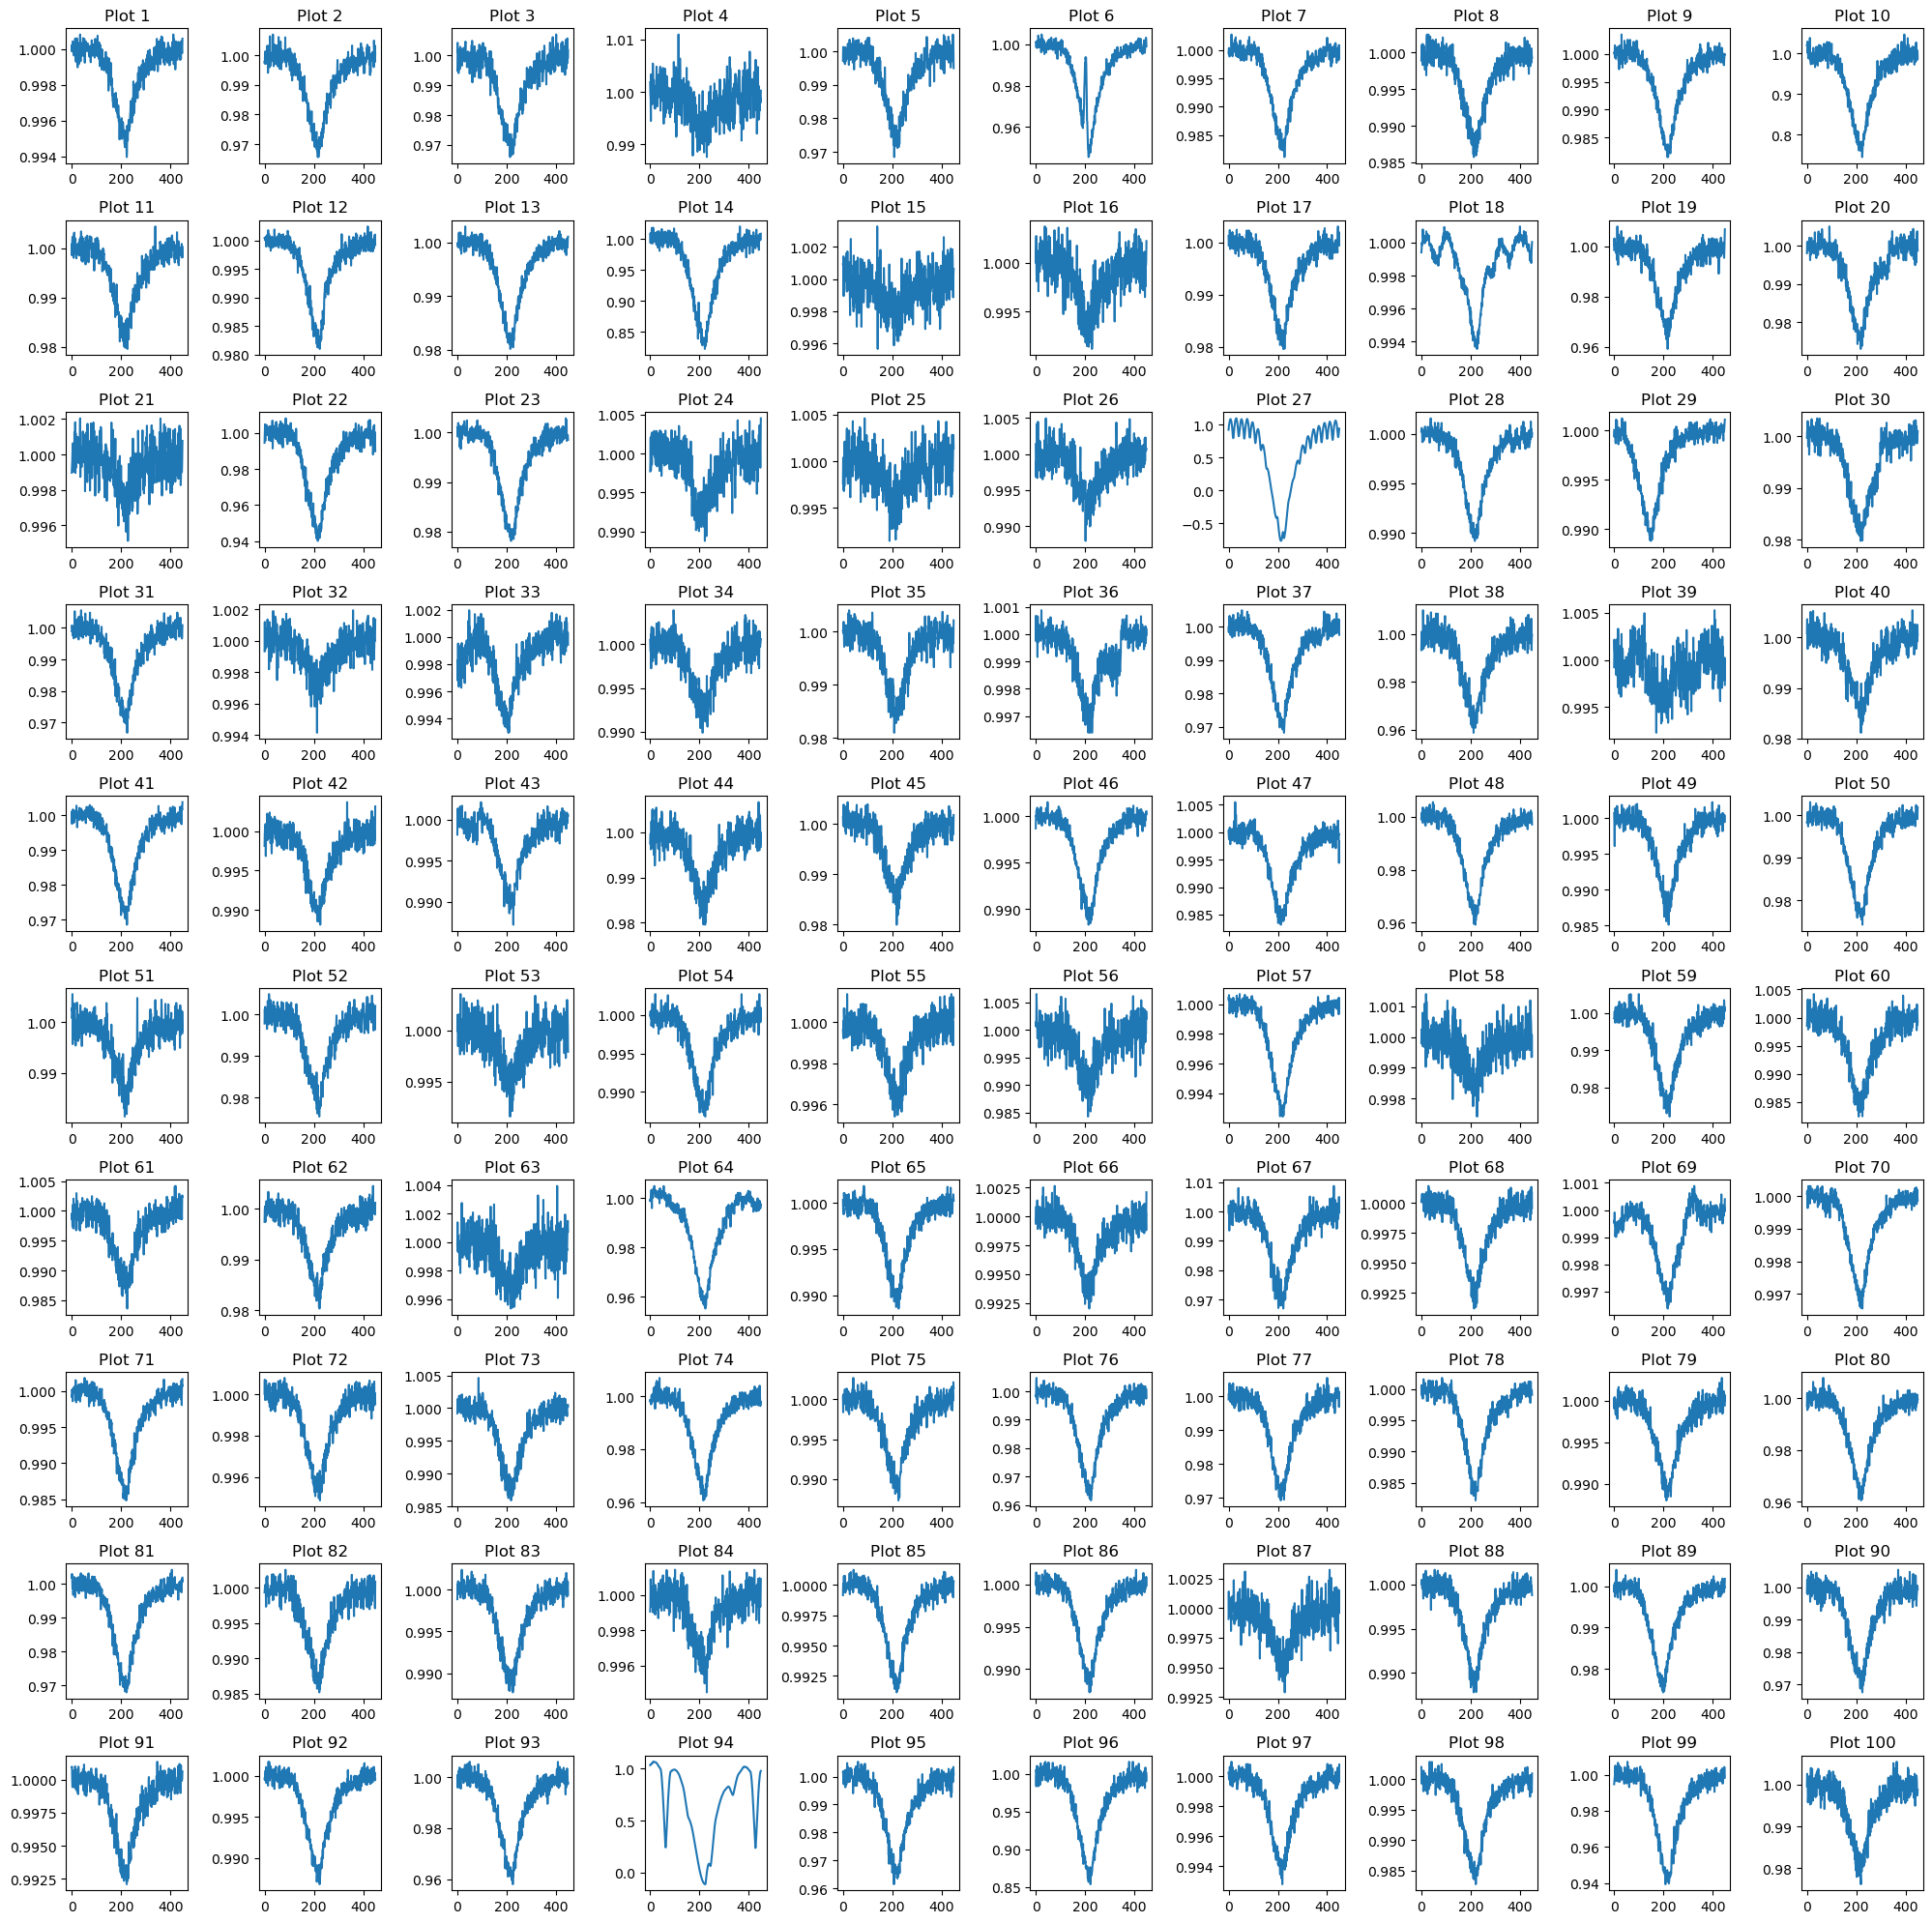

In [235]:
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break

## Run CNN

In [215]:
cnn = stella.ConvNN(output_dir='/Users/azib/Documents/open_source/nets/cnn-models/',ds=ds)

In [216]:
cnn.train_models(seeds=2, epochs=200,batch_size=64,shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 450, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 225, 16)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 225, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 225, 64)           3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 112, 64)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 64)           0

2024-04-22 18:17:32.670522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1108/1109 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5620 - precision: 0.5634 - recall: 0.9878

2024-04-22 18:17:50.235445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1109/1109 [==============================] - 20s 17ms/step - loss: 0.6871 - accuracy: 0.5619 - precision: 0.5633 - recall: 0.9878 - val_loss: 0.6848 - val_accuracy: 0.5648 - val_precision: 0.5648 - val_recall: 1.0000
Epoch 2/200
1109/1109 [==============================] - 19s 17ms/step - loss: 0.6854 - accuracy: 0.5632 - precision: 0.5632 - recall: 1.0000 - val_loss: 0.6851 - val_accuracy: 0.5648 - val_precision: 0.5648 - val_recall: 1.0000
Epoch 3/200
1109/1109 [==============================] - 17s 16ms/step - loss: 0.6854 - accuracy: 0.5632 - precision: 0.5632 - recall: 1.0000 - val_loss: 0.6848 - val_accuracy: 0.5648 - val_precision: 0.5648 - val_recall: 1.0000
Epoch 4/200
1109/1109 [==============================] - 16s 14ms/step - loss: 0.6853 - accuracy: 0.5632 - precision: 0.5632 - recall: 1.0000 - val_loss: 0.6849 - val_accuracy: 0.5648 - val_precision: 0.5648 - val_recall: 1.0000
Epoch 5/200
1109/1109 [==============================] - 17s 16ms/step - loss: 0.6852 - accuracy

/Users/azib/micromamba/envs/nets/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 24/278 [=>............................] - ETA: 0s 

2024-04-22 19:04:14.309330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 1s 2ms/step


In [217]:
cnn.history_table


loss_s0002,accuracy_s0002,precision_s0002,recall_s0002,val_loss_s0002,val_accuracy_s0002,val_precision_s0002,val_recall_s0002
float64,float64,float64,float64,float64,float64,float64,float64
0.6871362328529358,0.5618659853935242,0.5633193850517273,0.987817108631134,0.6847505569458008,0.5648106336593628,0.5648106336593628,1.0
0.6853682994842529,0.5632044672966003,0.5632044672966003,1.0,0.6850578188896179,0.5648106336593628,0.5648106336593628,1.0
...,...,...,...,...,...,...,...
0.6851651668548584,0.5632044672966003,0.5632044672966003,1.0,0.684729814529419,0.5648106336593628,0.5648106336593628,1.0
0.6851741671562195,0.5632044672966003,0.5632044672966003,1.0,0.6847415566444397,0.5648106336593628,0.5648106336593628,1.0


In [194]:
cnn.val_pred_table


tic,gt,tpeak,pred_s0042
float64,int64,float64,float32
389080829.0,1,2081.7640044236896,1.0
376935696.0,1,2079.5883150777768,1.0
...,...,...,...
389657219.0,0,2066.578388905205,1.0
394634836.0,1,2082.804999782426,1.0


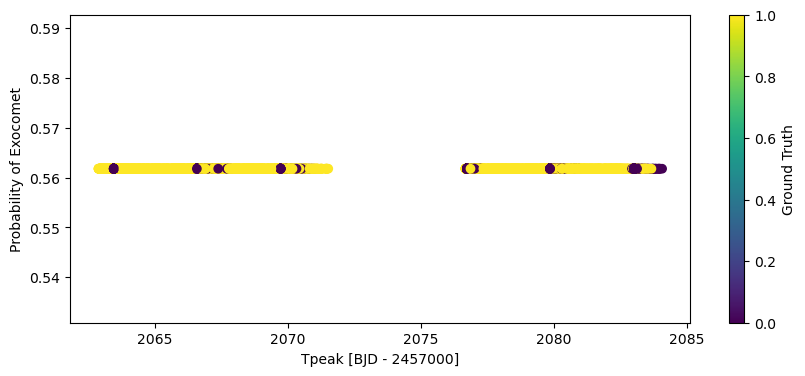

In [219]:
plt.figure(figsize=(10,4))
plt.scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table['pred_s0002'],
            c=cnn.val_pred_table['gt'], vmin=0, vmax=1)
plt.xlabel('Tpeak [BJD - 2457000]')
plt.ylabel('Probability of Exocomet')
plt.colorbar(label='Ground Truth');

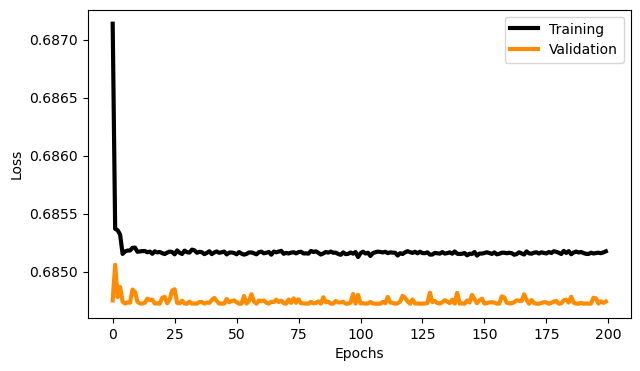

In [221]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['loss_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_loss_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

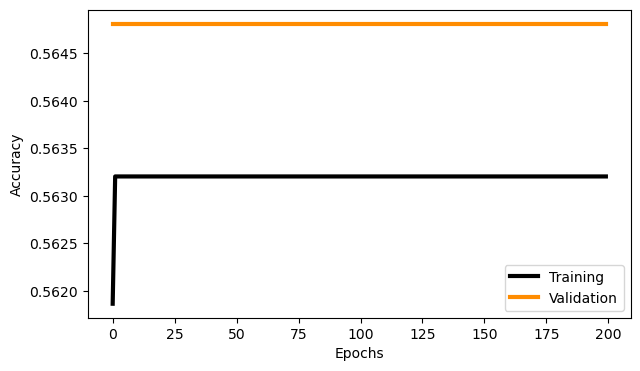

In [222]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['accuracy_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_accuracy_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

### Injecting two signals to test recovery

In [223]:
lc, lc_info = import_lightcurve('../data/s0028/target/0000/0003/9452/1654/hlsp_tess-spoc_tess_phot_0000000394521654-s0028_tess_v1_lc.fits')
#random_snr = np.random.uniform(min_snr,max_snr)
flat_flux = wotan.flatten(lc['TIME'], lc['SAP_FLUX'], method='median', window_length=2.5)
rms = np.std(flat_flux)
A = rms * 10

#     # Initialize a flag to indicate whether a valid time has been found
# valid_time_found = False

# while not valid_time_found:
#     t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])

#     # Check if the current random start time falls within any large gap or within 1.5 days before or after a gap
#     for index in large_gaps_indices:
#         start_time = lc['TIME'][index] - 1
#         end_time = lc['TIME'][index + 1] + 1
#         if start_time <= t0 <= end_time:
#             # Current random start time falls within a data gap or within 1.5 days before or after a gap, select a new one
#             break
#         elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
#             # Current random start time is within 1.5 days after a data gap, select a new one
#             break
#         elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
#             # Current random start time is within 1.5 days before a data gap, select a new one
#             break
#         elif t0 <= lc['TIME'][0] + 1:
#             # Current random start time is within one day after the beginning of the lightcurve, select a new one
#             break
#         elif t0 >= lc['TIME'][-1] - 2:
#             # Current random start time is within two days before the end of the lightcurve, select a new one
#             break
#     else:
#         # Current random start time doesn't fall within any data gap, 1.5 days before or after a gap, or special conditions, set the flag to True
#         valid_time_found = True


model = 1 - models.comet_curve(lc['TIME'], A, t0)
lc['SAP_FLUX'] = model * lc['SAP_FLUX']

B = rms * 5
model2 = 1 - models.comet_curve(lc['TIME'], B, 2080)
lc['SAP_FLUX'] = model2 * lc['SAP_FLUX']


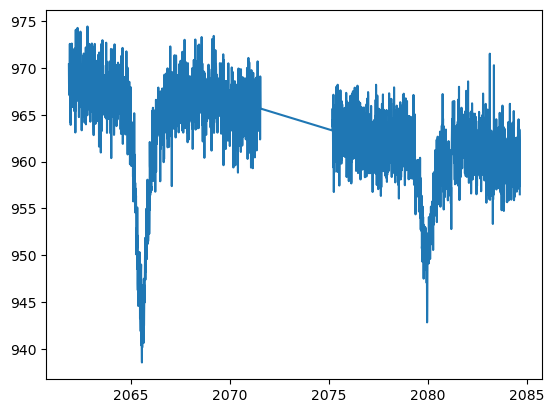

In [224]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [227]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets/cnn-models/ensemble_s0002_i0200_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

 1/86 [..............................] - ETA: 9s

2024-04-22 22:26:52.072005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 0s 3ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Text(0, 0.5, 'Normalized Flux')

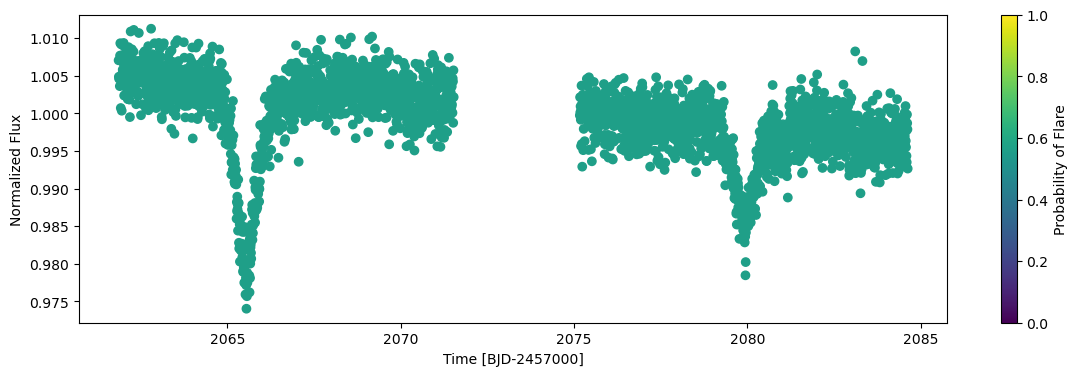

In [228]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
#plt.title('TIC {}'.format(lc.targetid));

Promising, but still more to do.

In [142]:
# def reformat_data(time, flux, flux_err, tpeaks, cadences=200, random_seed=321):
#     ss = 240000
#     training_matrix = np.zeros((ss, cadences))
#     training_labels = np.zeros(ss, dtype=int)
#     training_peaks = np.zeros(ss)
#     training_ids = np.zeros(ss)

#     x = 0

#     for i in tqdm(range(len(time))):
#         flares = np.array([], dtype=int)

#         if isinstance(tpeaks, (int, float)):
#             tpeaks = [tpeaks]
        
#         for peak in tpeaks[i]:
#             #tpeak is time of event
#             arg = np.where((time[i] > (peak - 0.02)) & (time[i] < (peak + 0.02)))[0]
#             if len(arg) > 0:
#                 closest = arg[np.argmin(np.abs(peak - time[i][arg]))]
#                 start = int(closest - cadences / 2)
#                 end = int(closest + cadences / 2)
#                 if start < 0:
#                     start = 0
#                     end = cadences
#                 if end > len(time[i]):
#                     start = start - (end - len(time[i]))
#                     end = len(time[i])
#                 flare_region = np.arange(start, end, 1, dtype=int)
#                 flares = np.append(flares, flare_region)

#                 training_peaks[x] = time[i][closest] + 0.0
#                 training_ids[x] = ids[i] + 0.0
#                 training_matrix[x] = flux[i][flare_region]
#                 training_labels[x] = 1
#                 x += 1

#         time_removed = np.delete(time[i], flares)
#         flux_removed = np.delete(flux[i], flares)
#         flux_err_removed = np.delete(flux_err[i], flares)

#         nontime, nonflux, nonerr = break_rest(time_removed, flux_removed,
#                                               flux_err_removed, cadences)
#         for j in range(len(nonflux)):
#             if x >= ss:
#                 break
#             else:
#                 training_ids[x] = ids[i] + 0.0
#                 training_peaks[x] = nontime[j][int(cadences / 2)]
#                 training_matrix[x] = nonflux[j]
#                 training_labels[x] = 0
#                 x += 1

#     training_matrix = np.delete(training_matrix, np.arange(x, ss, 1, dtype=int), axis=0)
#     labels = np.delete(training_labels, np.arange(x, ss, 1, dtype=int))
#     training_peaks = np.delete(training_peaks, np.arange(x, ss, 1, dtype=int))
#     training_ids = np.delete(training_ids, np.arange(x, ss, 1, dtype=int))

#     ids, matrix, label, peaks = do_the_shuffle(training_matrix, labels, training_peaks,
#                                                training_ids, frac_balance)
#     return label, peaks, ids, matrix

# def break_rest(time, flux, flux_err, cadences):
#     """
#     Breaks up the non-signal cases into bite-sized cadence-length chunks.

#     Parameters
#     ----------
#     time : np.ndarray
#          Array of time.
#     flux : np.ndarray
#          Array of fluxes.
#     flux_err : np.ndarray
#          Array of flux errors.
#     cadences : int
#          Number of cadences for the training-validation-test set.

#     Returns
#     -------
#     time : np.ndarray
#          Array of times without the signal.
#     flux : np.ndarray
#          Array of fluxes without the signal.
#     err : np.ndarray
#          Array of flux errors without the signal.
#     """
#     # BREAKING UP REST OF LIGHT CURVE INTO CADENCE SIZED BITES     
#     print(type(time))
#     diff = np.diff(time)
#     breaking_points = np.where(diff > (np.median(diff) + 1.5*np.std(diff)))[0]
    
#     tot = 100
#     ss  = 1000
#     nonflare_time = np.zeros((ss, cadences))
#     nonflare_flux = np.zeros((ss, cadences))
#     nonflare_err = np.zeros((ss, cadences))
    
#     x = 0
#     for j in range(len(breaking_points)+1):
#         if j == 0:
#             start = 0
#             end = breaking_points[j]
#         elif j < len(breaking_points):
#             start = breaking_points[j-1]
#             end = breaking_points[j]
#         else:
#             start = breaking_points[-1]
#             end = len(time)

#         if np.abs(end-start) > (2*cadences):
#             broken_time = time[start:end]
#             broken_flux = flux[start:end]
#             broken_err  = flux_err[start:end]

#             # DIVIDE LIGHTCURVE INTO EVEN BINS                                                                        
#             c = 0
#             while (len(broken_time) - c) % cadences != 0:
#                 c += 1

#             # REMOVING CADENCES TO BIN EVENLY INTO CADENCES                                                           
#             temp_time = np.delete(broken_time, np.arange(len(broken_time)-c,
#                                                          len(broken_time), 1, dtype=int) )
#             temp_flux = np.delete(broken_flux, np.arange(len(broken_flux)-c,
#                                                          len(broken_flux), 1, dtype=int) )
#             temp_err = np.delete(broken_err, np.arange(len(broken_err)-c,
#                                                        len(broken_err), 1, dtype=int) )

#             # RESHAPE ARRAY FOR INPUT INTO MATRIX                                                                     
#             temp_time = np.reshape(temp_time,
#                                    (int(len(temp_time) / cadences), cadences) )
#             temp_flux = np.reshape(temp_flux,
#                                    (int(len(temp_flux) / cadences), cadences) )
#             temp_err  = np.reshape(temp_err,
#                                    (int(len(temp_err) / cadences), cadences) )
            
#             # APPENDS TO BIGGER MATRIX                                                                                
#             for f in range(len(temp_flux)):
#                 if x >= ss:
#                     break
#                 else:
#                     nonflare_time[x] = temp_time[f]
#                     nonflare_flux[x] = temp_flux[f]
#                     nonflare_err[x] = temp_err[f]
#                     x += 1

#     nonflare_time = np.delete(nonflare_time, np.arange(x, ss, 1, dtype=int), axis=0)
#     nonflare_flux = np.delete(nonflare_flux, np.arange(x, ss, 1, dtype=int), axis=0)
#     nonflare_err  = np.delete(nonflare_err,  np.arange(x, ss, 1, dtype=int), axis=0)
    
#     return nonflare_time, nonflare_flux, nonflare_err